# Sparkify Project Workspace

This project is the analysis of a dataset that contains user logs for a music streaming service called "Sparkify" (no need to search for it it does not exist). This is my submission to the capstone project of the Udacity data scientist nanodegree.

## Overview <a id='overview'></a>
Sparkify is a music streaming service just as Spotify and Pandora. 

The data provided is the user log of the service, having demographic info, user activities, timestamps and etc. We try to analyze the log and build a model to identify customers who are highly likely to quit using our service, and thus, send marketing offers to them to prevent them from churning. 

We use F1 score to measure of model performance because we need precision and recall at the same time as we don't want to miss too many customers who are likely to churn whilst we don't want to waste too much on those who are not likely to churn. 

We performed EDA to establish features, and train several machine learning classification models.

The model we built and selected has a F1 score of 0.800, which is 16% higher than sending everybody offers. There is also a short article about this project posted here.

The Sparkify music service looks to identify the population of users that churn (they can be users from the free service, or the paid service). Once the possible criteria for churn are better undestood, our objective is to build a model and predict the users churn so that some specific attention can be given to the users and try to retain them on the platform.

We will be using a tiny subset (128MB) of the full dataset available (12GB). The provided dataset contains the logs of the user actions (pages seen by users along with other encoded properties such as location, time, operating system used, subscription level of the user for example).

The notebook is separated in the following sections:
- [Load and Clean Dataset](#Load-and-Clean-Dataset)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Define Churn](#Define-Churn)
  - [Explore Data](#Explore-Data)
- [Feature Engineering](#Feature-Engineering)
- [Modeling](#Modeling)
- [Conclusion](#Conclusion)


In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, sum as Fsum, avg, count, max as Fmax, min, col, last, regexp_extract
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, we will be loading either the mini-dataset file in `mini_sparkify_event_data.json`, or a larger dataset from the AWS S3 bucket. We have done the first pass using the small dataset, and before publishing the results, we have used the large dataset for actual data analysis. We will first load and clean the dataset, checking for invalid or missing data.

In [3]:
#choose the mini dataset from the local file
event_data = "mini_sparkify_event_data.json"

In [6]:
# load the data into spark
df = spark.read.json(event_data)
df.persist()
df.head()
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# print the number of rows in the data
count1 = df.count()

# remove records with a missing userId or sessionId
df = df.dropna(how="any", subset=["userId", "sessionId"])

# print the count of remaining rows
count2 = count1 - df.count()

print(count2)

0


No rows were removed, which means there were no "nan" values in the userId or sessionId fields

In [8]:
# identify records with invalid value of userId
df.groupBy("userId").count().orderBy("userId").show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



In [9]:
# get an overview of all columns, use a for loop so the display of each column is in its own "table", which makes it more readable than
# the default "wide" view of df.describe()
for c in df.columns:
    df.describe(c).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141085|
|    min|                 0|
|    max| 

In [10]:
# remove the rows with an empty userId. This will exclude all logged out users from the remainder of the analysis
df = df.filter(df["userId"]!="")

# print the count of remaining rows
count3 = count1 - df.count()

print(count3)

8346


In [11]:
# show records with invalud value of sessionId
df.groupBy("sessionId").count().orderBy("sessionId").show()

+---------+-----+
|sessionId|count|
+---------+-----+
|        1|  680|
|        2|    7|
|        3|   37|
|        4|   24|
|        5|   57|
|        6|   68|
|        7|    1|
|        8|   45|
|        9|  190|
|       10|  165|
|       11|   46|
|       12|   59|
|       13|  119|
|       15|  213|
|       16|   39|
|       17|  169|
|       18|   27|
|       19|  151|
|       20|   29|
|       21|  127|
+---------+-----+
only showing top 20 rows



There are apparently no invalid values in the sessionId column

# Exploratory Data Analysis
In the following section we will explore the data to get a feeling of how it is structured, and understand the specific information that could help us identify when a user would churn or not.

In [12]:
# display the possible pages used in the dataset
df.select("page").dropDuplicates().sort("page").show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [13]:
# display the possible auth values used in the dataset
df.select("auth").dropDuplicates().sort("auth").show()

# display the possible levels used in the dataset
df.select("level").dropDuplicates().sort("level").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [14]:
# display the possible values for the platform, extracted from user agent field
# prepare a regex extraction function
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
df.select(re).replace(["iPad","iPhone","Macintosh","X11","Windows","compatible"],
                      ["Apple","Apple","Apple","Linux","Windows","Windows"], "platform").dropDuplicates().show()

+--------+
|platform|
+--------+
|   Linux|
|   Apple|
| Windows|
+--------+



In [15]:
# identify the pages associated with a given HTTP method
df.groupBy(["page","method"]).count().orderBy("page").show(30)

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|          Add Friend|   PUT|  4277|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|Cancellation Conf...|   GET|    52|
|           Downgrade|   GET|  2055|
|               Error|   GET|   252|
|                Help|   GET|  1454|
|                Home|   GET| 10082|
|              Logout|   PUT|  3226|
|            NextSong|   PUT|228108|
|         Roll Advert|   GET|  3933|
|       Save Settings|   PUT|   310|
|            Settings|   GET|  1514|
|    Submit Downgrade|   PUT|    63|
|      Submit Upgrade|   PUT|   159|
|         Thumbs Down|   PUT|  2546|
|           Thumbs Up|   PUT| 12551|
|             Upgrade|   GET|   499|
+--------------------+------+------+



Every page is associated only with a defined method. Therefore the method column does not provide additional information on the usage of the site by users, it is only a technical object that is linked to the way the page is implemented.

In [16]:
# show the number of unique users
print(df.select("userId").dropDuplicates().count())

# show the number of unique registrations
print(df.select("registration").dropDuplicates().count())

# identify if there is a 1:1 match between userId and registration
print(df.select(["userId","registration"]).dropDuplicates().count())

225
225
225


The fact that the following values are equal mean there is a 1:1 relationship between userId and registration:
- individual count of distinct userId values
- individual count of distinct registration values
- count of pairs made up with registration and userId values

Registration also seems to be only a technical identifier that does not provide additional information on top of the userId field

In [17]:
# explore sessionId field
df.groupBy(["userId","sessionId"]).count().orderBy(["userId","sessionId"]).show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    10|        9|   70|
|    10|      595|  449|
|    10|     1047|   25|
|    10|     1414|   78|
|    10|     1592|   78|
|    10|     1981|   95|
|   100|      256|  177|
|   100|      369|  108|
|   100|      435|   17|
|   100|      556|  287|
|   100|      683|   32|
|   100|      707|  220|
|   100|      991|   20|
|   100|     1049|   82|
|   100|     1185|  170|
|   100|     1210|   80|
|   100|     1231|   18|
|   100|     1269|    5|
|   100|     1279|   31|
|   100|     1299|   96|
+------+---------+-----+
only showing top 20 rows



As we could expect, each user is having multiple sessions, with a variable number of actions during each session

In [18]:
# display the possible pages status used in the dataset
df.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



HTTP statuses reference is available on https://httpstatuses.com/

Specifically for the ones available in the above table:
- https://httpstatuses.com/200 - page ok
- https://httpstatuses.com/307 - temporary redirect
- https://httpstatuses.com/404 - page not found

In [19]:
# Show the pages with a redirect
df.filter(df["status"]=="307").groupBy(["auth","page"]).count().orderBy("auth").show()

# Show the pages with an Error
df.filter(df["status"]=="404").groupBy(["auth","page"]).count().orderBy("auth").show()

# example of a user with error in the activities
df.filter(df["status"]=="404").show(5)

+---------+----------------+-----+
|     auth|            page|count|
+---------+----------------+-----+
|Logged In|          Logout| 3226|
|Logged In|   Save Settings|  310|
|Logged In|      Add Friend| 4277|
|Logged In|          Cancel|   52|
|Logged In|       Thumbs Up|12551|
|Logged In|     Thumbs Down| 2546|
|Logged In|  Submit Upgrade|  159|
|Logged In|Submit Downgrade|   63|
+---------+----------------+-----+

+---------+-----+-----+
|     auth| page|count|
+---------+-----+-----+
|Logged In|Error|  252|
+---------+-----+-----+

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+-------------------

In [20]:
df.select(["userId", "firstname", "sessionId", "auth", "page", "status", "level", "song"]).where(df.userId == "17").show()

+------+---------+---------+---------+-----------+------+-----+--------------------+
|userId|firstname|sessionId|     auth|       page|status|level|                song|
+------+---------+---------+---------+-----------+------+-----+--------------------+
|    17|    Kayla|      250|Logged In|       Home|   200| free|                null|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|      Pork And Beans|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Pursuit Of Happin...|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|     God Isn't Dead?|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|        By My Spirit|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Best Imitation Of...|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Language Lessons ...|
|    17|    Kayla|      250|Logged In|Roll Advert|   200| free|                null|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Ta

In [21]:
# show users who have changes status during the period captured in the dataset
df.withColumn("userId", df["userId"].cast(IntegerType())).groupBy(["userId","level","auth"]).count().orderBy("userId").show()

+------+-----+---------+-----+
|userId|level|     auth|count|
+------+-----+---------+-----+
|     2| paid|Logged In|  899|
|     3| paid|Cancelled|    1|
|     3| paid|Logged In|  253|
|     4| free|Logged In|  141|
|     4| paid|Logged In| 2301|
|     5| free|Logged In|  218|
|     6| free|Logged In|   84|
|     6| paid|Logged In| 3677|
|     7| free|Logged In|  201|
|     8| free|Logged In|  334|
|     9| paid|Logged In| 2934|
|     9| free|Logged In|  257|
|    10| paid|Logged In|  795|
|    11| paid|Logged In|  229|
|    11| free|Logged In|  619|
|    12| paid|Cancelled|    1|
|    12| free|Logged In|  442|
|    12| paid|Logged In|  621|
|    13| paid|Logged In|  452|
|    13| free|Logged In| 1202|
+------+-----+---------+-----+
only showing top 20 rows



## Define Churn

After this preliminary analysis, we will create a column `churn` to use as the label for the model. We will be using the `Cancellation Confirmation` events to define churn, which happen for both paid and free users.

In [22]:
# Add the Churn column
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", flag_cancel_event("page"))

# repeat the churn flag for all rows of the users who churned
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", Fsum("churn").over(windowval))

# find an example of Cancellation record
df.filter("page = 'Cancellation Confirmation'").head()

Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='GET', page='Cancellation Confirmation', registration=1533157139000, sessionId=174, song=None, status=200, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', churn=1)

## Explore Data
We will now perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We will be exploring aggregates on these two groups of users

In [23]:
# show an example of a user journey to Cancellation, this will be displayed with most recent record ("cancellation") on top
df.select(["userId", "sessionId", "ts", "page", "level", "churn"]) \
    .where(df.userId=="18") \
    .where(df.sessionId=="514") \
    .sort("ts", ascending=False) \
    .head(20)

[Row(userId='18', sessionId=514, ts=1538943990000, page='Cancellation Confirmation', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943740000, page='Cancel', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943739000, page='Downgrade', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943726000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943440000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943117000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942837000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942663000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942425000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942030000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538941694000, page='NextSon

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



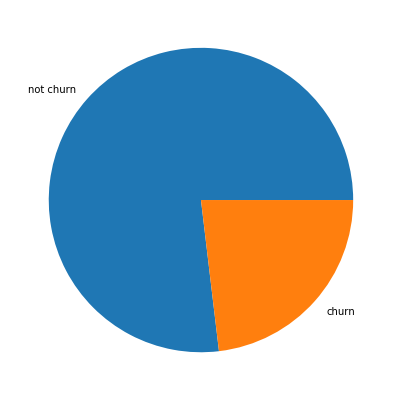

In [24]:
# count how many users churn vs the others
churn = df.select(["userId", "churn"]).dropDuplicates().groupBy("churn").count()

churn.show()

# plot the ratio of users who churn vs. others
pd_df = churn.toPandas()
fig=plt.figure(figsize=(7,7))
plt.pie(x=pd_df["count"], labels=["not churn","churn"]);

A little less than a quarter of the users perform churn

+-----+------+-----+-------------------+
|churn|gender|count|            percent|
+-----+------+-----+-------------------+
|    0|     F|   84|0.48554913294797686|
|    0|     M|   89| 0.5144508670520231|
|    1|     F|   20|0.38461538461538464|
|    1|     M|   32| 0.6153846153846154|
+-----+------+-----+-------------------+



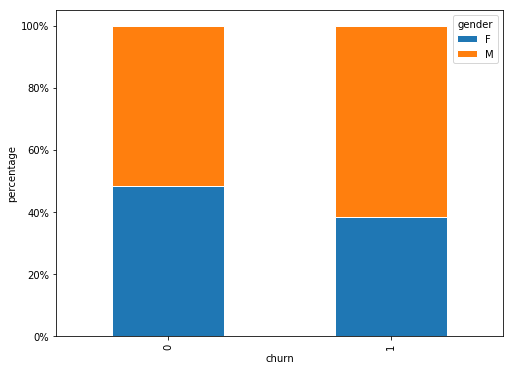

In [25]:
# compare the gender of the users who churn vs. users who do not churn
gender = df.select(["userId", "gender", "churn"]).dropDuplicates() \
    .groupBy("churn", "gender").count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy(["churn", "gender"])

gender.show()

# plot the churn by gender information
pd_df = gender.toPandas()

pd_df = pd_df.pivot(index='churn', columns='gender', values='percent');
pd_df.plot.bar(stacked=True, figsize=(8,6), edgecolor='white');

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

The Male population is more likely to churn, relative to the total number of users in their category

+-----+------+-------------+
|churn|userId|count(artist)|
+-----+------+-------------+
|    0|100010|          252|
|    0|200002|          339|
|    1|   125|            8|
|    0|   124|         2232|
|    1|    51|         1385|
|    0|     7|          142|
|    0|    15|         1302|
|    1|    54|         1744|
|    0|   155|          643|
|    1|100014|          233|
|    0|   132|         1299|
|    0|   154|           78|
|    1|   101|         1241|
|    0|    11|          534|
|    0|   138|         1332|
|    0|300017|         2070|
|    1|100021|          207|
|    1|    29|         1804|
|    0|    69|          865|
|    0|   112|          195|
+-----+------+-------------+
only showing top 20 rows

+-----+------------------+
|churn|avg(count(artist))|
+-----+------------------+
|    0| 749.7861271676301|
|    1| 518.6923076923077|
+-----+------------------+



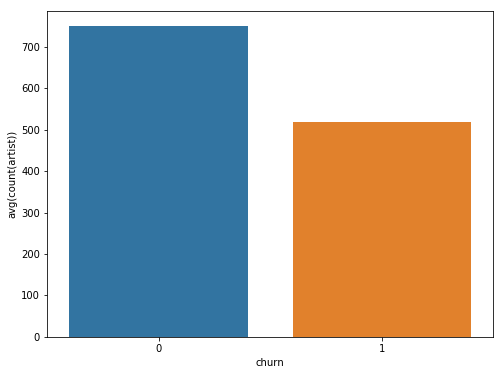

In [26]:
# show total number of different artists that each user listens to
df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist", "churn"]).dropDuplicates() \
    .groupBy(["churn", "userId"]).agg(count("artist")) \
    .show()

# show average number of different artists that users listen to between users who churn vs. users who do not churn
diversity = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist", "churn"]).dropDuplicates() \
    .groupBy(["churn", "userId"]).agg(count("artist")) \
    .groupBy("churn").agg(avg("count(artist)"))

diversity.show()

# plot the churn by diversity information
pd_df = diversity.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(count(artist))", data=pd_df);

The users who churn are listening to a smaller number of artists over the period of time of the dataset. It is possble that this result is influenced by the fact they are not staying as long on the service, so we will look at the same information, but based on the session instead

+-----+-----+-----+-------------------+
|churn|level|count|            percent|
+-----+-----+-----+-------------------+
|    0| free|  133| 0.7687861271676301|
|    0| paid|   40|0.23121387283236994|
|    1| free|   44| 0.8461538461538461|
|    1| paid|    8|0.15384615384615385|
+-----+-----+-----+-------------------+



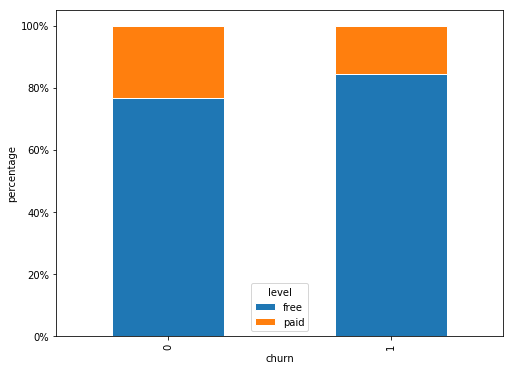

In [27]:
# compare the level (paid/free) of the users who churn vs. users who do not churn
# we want the last level of the user in the dataset, as the level of a user can evolve over time
partition_window = Window.partitionBy(["userId"])

level = df.select(col("userId"), last("level").over(partition_window).alias("level"), col("churn")).dropDuplicates() \
    .groupBy("churn", "level").count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy(["churn", "level"])

level.show()

# plot the churn by level information
pd_df = level.toPandas()

pd_df = pd_df.pivot(index='churn', columns='level', values='percent');
pd_df.plot.bar(stacked=True, figsize=(8,6), edgecolor='white');

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

The free users are slightly more likely to churn than paid users

+-----+------------------+
|churn|avg(count(artist))|
+-----+------------------+
|    0| 70.10344827586206|
|    1| 65.69171483622351|
+-----+------------------+



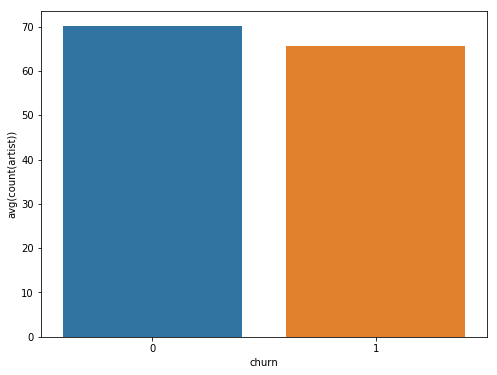

In [28]:
# show average number of different artists per session that users listen to between users who churn vs. users who do not churn
diversity_per_session = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "sessionId", "artist", "churn"]).dropDuplicates() \
    .groupBy(["churn", "userId", "sessionId"]).agg(count("artist")) \
    .groupBy("churn").agg(avg("count(artist)"))

diversity_per_session.show()

# plot the churn by diversity per sessioninformation
pd_df = diversity_per_session.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(count(artist))", data=pd_df);

This chart confirms that the users who churn are listening to a smaller diversity of artists per session.

+-----+--------+-----+-------------------+
|churn|platform|count|            percent|
+-----+--------+-----+-------------------+
|    0|   Apple|   79|0.45664739884393063|
|    1|   Apple|   23| 0.4423076923076923|
|    0|   Linux|    7|0.04046242774566474|
|    1|   Linux|    5|0.09615384615384616|
|    0| Windows|   87| 0.5028901734104047|
|    1| Windows|   24|0.46153846153846156|
+-----+--------+-----+-------------------+



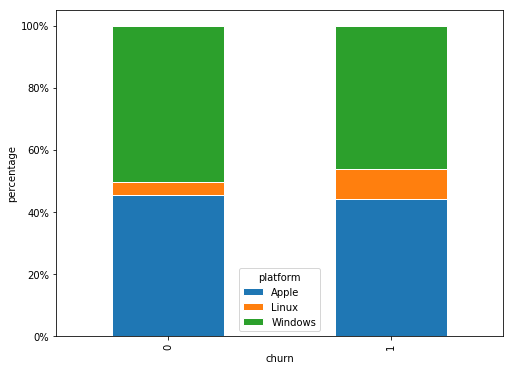

In [29]:
# display the possible values for the platform, extracted from user agent field
# prepare a regex extraction function we keep only the first word of the platform
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
platform = df.select([re, "userId", "churn"]) \
    .replace(["iPad", "iPhone", "Macintosh", "X11", "Windows", "compatible"],
             ["Apple", "Apple", "Apple", "Linux", "Windows", "Windows"], "platform").dropDuplicates() \
    .groupBy(["churn", "platform"]).count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy("platform")

platform.show()

# plot the churn by platform information
pd_df = platform.toPandas()

pd_df = pd_df.pivot(index='churn', columns='platform', values='percent');
pd_df.plot.bar(stacked=True, figsize=(8,6), edgecolor='white');

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

There seems to be no difference on the number of times they listen to songs from the same artist between the churn users and users who continue using the service

+-----+------+---------+----------+
|churn|userId|sessionId|max(count)|
+-----+------+---------+----------+
|    0|   115|      316|        12|
|    0|    91|     1840|        12|
|    0|    61|      529|        10|
|    0|    41|      377|         9|
|    0|   132|     1494|         8|
|    0|     4|     1737|         7|
|    0|   128|     2206|         7|
|    0|    95|      541|         7|
|    0|300002|      436|         7|
|    0|    25|      827|         7|
|    0|   138|     2305|         7|
|    0|   100|      556|         7|
|    0|   124|      708|         7|
|    0|200014|      361|         7|
|    1|   103|     1117|         7|
|    0|    42|     1646|         7|
|    0|    89|     1271|         7|
|    0|   124|     1394|         7|
|    1|   101|      635|         7|
|    0|   138|     1305|         7|
+-----+------+---------+----------+
only showing top 20 rows

+-----+------------------+
|churn|   avg(max(count))|
+-----+------------------+
|    0|1.8875391849529781|
| 

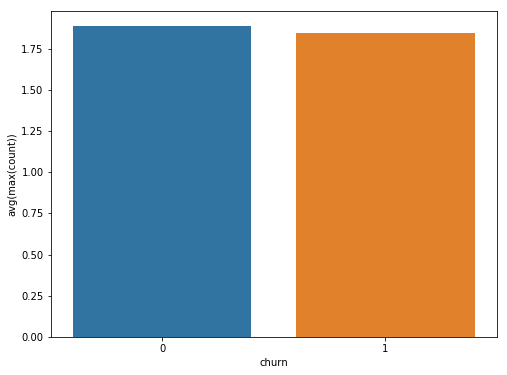

In [30]:
# show highest number of times the same artist was played by each user in each session
df.filter(df["artist"].isNotNull()) \
    .groupBy(["churn", "sessionId", "userId", "artist"]).count() \
    .groupBy(["churn","userId", "sessionId"]).agg(Fmax("count")) \
    .orderBy("max(count)", ascending=False).show()

# show average highest number of times the same artist was played by each user in each session between users who churn vs. users who do not churn
repeat_artist_per_session = df.filter(df["artist"].isNotNull()) \
    .groupBy(["churn", "sessionId", "userId", "artist"]).count() \
    .groupBy(["churn", "userId", "sessionId"]).agg(Fmax("count")) \
    .groupBy("churn").agg(avg("max(count)"))

repeat_artist_per_session.show()

# plot the churn by diversity per session
pd_df = repeat_artist_per_session.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(max(count))", data=pd_df);

It looks like the Linux users are overrepresented in the churn population vs. in the non-churn population. We will display the information differently to confirm this information.

In [31]:
# identify if we have users that use multiple platforms (i.e. bridge across Apple, Windows, Linux worlds)
# prepare a regex extraction function
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
platform_count = df.select(["userId", re]) \
    .replace(["iPad","iPhone","Macintosh","X11","Windows","compatible"],
             ["Apple","Apple","Apple","Linux","Windows","Windows"], "platform") \
    .dropDuplicates() \
    .groupBy(["userId", "platform"]).count() \
    .filter(col("count")>1)

platform_count.show()
platform_count.count()

+------+--------+-----+
|userId|platform|count|
+------+--------+-----+
+------+--------+-----+



0

+--------+-------------------+-------------------+--------------------+
|platform|      churn_percent|   no_churn_percent|               ratio|
+--------+-------------------+-------------------+--------------------+
|   Linux|0.09615384615384616|0.04046242774566474|  1.3763736263736264|
|   Apple| 0.4423076923076923|0.45664739884393063|-0.03140214216163584|
| Windows|0.46153846153846156| 0.5028901734104047|-0.08222811671087538|
+--------+-------------------+-------------------+--------------------+



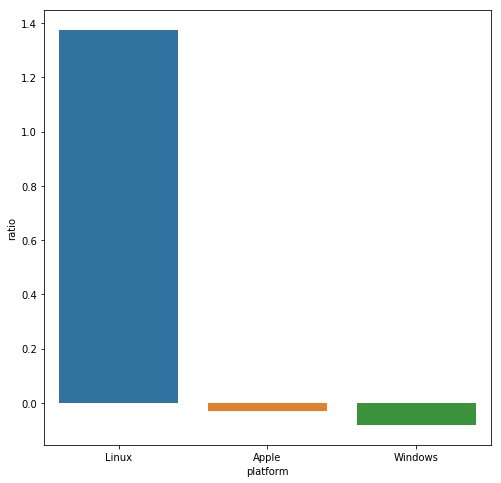

In [32]:
# show the comparison information in a more visual format
platform_churn = platform.filter(platform["churn"]==1).select(["platform","percent"]).withColumnRenamed('percent','churn_percent')
platform_no_churn = platform.filter(platform["churn"]==0).select(["platform","percent"]).withColumnRenamed('percent','no_churn_percent')

# join the tables to be able to compare the data
compare_platform = platform_churn.join(platform_no_churn, on="platform", how="outer")
compare_platform = compare_platform.withColumn("ratio", col("churn_percent")/col("no_churn_percent")-1)

compare_platform.show()

# plot the platforms that are more present in the group of "Churn" users
pd_df = compare_platform.toPandas().dropna()
fig=plt.figure(figsize=(8,8))
sns.barplot(x="platform", y="ratio", data=pd_df);

In our dataset we can see users are loyal to their platform of choice, and we have no cross-platform users which will make the analysis easier later on (modeling based on this information does not need to take care of users with possibly multiple platforms).

This visualisation confirms that the Linux users are indeed more likely to be present in the churn group.

+-----+------------------+
|churn|        avg(count)|
+-----+------------------+
|    0| 56.95603089720737|
|    1|40.392896781354054|
+-----+------------------+



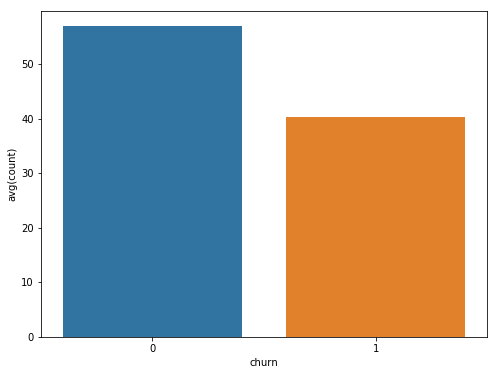

In [33]:
# count the number of songs played per hour on average between churn users and non-churn users
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))
songs_in_hour = df.filter(df.page == "NextSong").groupby(["userId", "churn", df.hour]).count().orderBy(["userId", df.hour.cast("float")])
songs_in_hour_avg = songs_in_hour.groupBy("churn").agg(avg("count"))

songs_in_hour_avg.show()

# plot the averages number of songs played per hour
pd_df = songs_in_hour_avg.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(count)", data=pd_df);

on average, the users who are ending up in the churn group, have a lower number of songs played per hour than the other users

In [34]:
# comparison of the pages between the users who churn vs. users who do not churn
pages = df.groupBy(["churn","page"]).count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy(["churn","percent"])

pages.show(40)

+-----+--------------------+------+--------------------+
|churn|                page| count|             percent|
+-----+--------------------+------+--------------------+
|    0|    Submit Downgrade|    54| 2.31471559003815E-4|
|    0|      Submit Upgrade|   127|5.443868146941575E-4|
|    0|               Error|   220|  9.4303227742295E-4|
|    0|       Save Settings|   252| 0.00108020060868447|
|    0|             Upgrade|   387|0.001658879506194...|
|    0|               About|   439|0.001881778044493...|
|    0|                Help|  1215|0.005208110077585837|
|    0|            Settings|  1244| 0.00533241887779159|
|    0|           Downgrade|  1718|0.007364224784602855|
|    0|         Thumbs Down|  2050|0.008787346221441126|
|    0|              Logout|  2673|0.011457842170688843|
|    0|         Roll Advert|  2966|0.012713789703802134|
|    0|          Add Friend|  3641|0.015607184191349823|
|    0|     Add to Playlist|  5488|0.023524368811350678|
|    0|                Home|  8

We will have to filter out the "NextSong" page, as represent more than 80% of all the pages viewed and will not allow us to read the charts.

In [35]:
# comparison of the pages between the users who churn vs. users who do not churn
pages = df.groupBy(["churn","page"]).count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy(["churn","percent"])

pages.show(40)

+-----+--------------------+------+--------------------+
|churn|                page| count|             percent|
+-----+--------------------+------+--------------------+
|    0|    Submit Downgrade|    54| 2.31471559003815E-4|
|    0|      Submit Upgrade|   127|5.443868146941575E-4|
|    0|               Error|   220|  9.4303227742295E-4|
|    0|       Save Settings|   252| 0.00108020060868447|
|    0|             Upgrade|   387|0.001658879506194...|
|    0|               About|   439|0.001881778044493...|
|    0|                Help|  1215|0.005208110077585837|
|    0|            Settings|  1244| 0.00533241887779159|
|    0|           Downgrade|  1718|0.007364224784602855|
|    0|         Thumbs Down|  2050|0.008787346221441126|
|    0|              Logout|  2673|0.011457842170688843|
|    0|         Roll Advert|  2966|0.012713789703802134|
|    0|          Add Friend|  3641|0.015607184191349823|
|    0|     Add to Playlist|  5488|0.023524368811350678|
|    0|                Home|  8

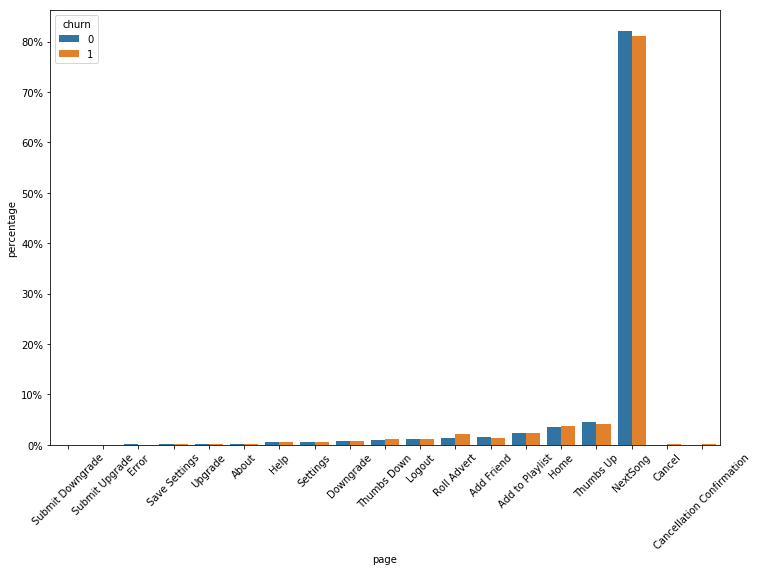

In [36]:
# plot the churn by pages information
pd_df = pages.toPandas()
fig=plt.figure(figsize=(12,8))
sns.barplot(x="page", y="percent", hue="churn", data=pd_df);
plt.xticks(rotation=45);

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

The "NextSong" action dominates the dataset. We will be looking at the data from a different perspective, we would like to see what are the pages that are more seen by churn users vs. the non churn users

In [37]:
# show the comparison information in a more visual format
pages_churn = pages.filter(pages["churn"]==1).select(["page","percent"]).withColumnRenamed('percent','churn_percent')
pages_no_churn = pages.filter(pages["churn"]==0).select(["page","percent"]).withColumnRenamed('percent','no_churn_percent')

# join the tables to be able to compare the data
compare_pages = pages_churn.join(pages_no_churn, on="page", how="outer")
compare_pages = compare_pages.withColumn("ratio", col("churn_percent")/col("no_churn_percent")-1)

compare_pages.show()

+--------------------+--------------------+--------------------+--------------------+
|                page|       churn_percent|    no_churn_percent|               ratio|
+--------------------+--------------------+--------------------+--------------------+
|              Cancel|0.001159058487874...|                null|                null|
|    Submit Downgrade|2.006062767475035...| 2.31471559003815E-4|-0.13334373514027587|
|         Thumbs Down|0.011055634807417974|0.008787346221441126|  0.2581312410841654|
|                Home|0.037268188302425106| 0.03604955205966823| 0.03380447670306208|
|           Downgrade|0.007511590584878745|0.007364224784602855| 0.02001104048100255|
|         Roll Advert|0.021554029957203995|0.012713789703802134|  0.6953269213473097|
|              Logout| 0.01232614122681883|0.011457842170688843| 0.07578207512329405|
|       Save Settings|0.001292796005706134| 0.00108020060868447| 0.19681103242533338|
|Cancellation Conf...|0.001159058487874...|           

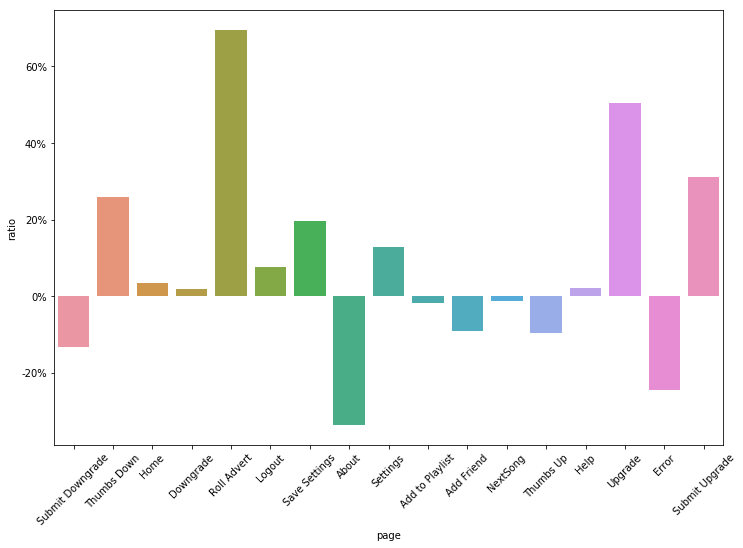

In [38]:
# plot the pages that are more viewed in the group of "Churn" users
pd_df = compare_pages.toPandas().dropna()
fig=plt.figure(figsize=(12,8))
sns.barplot(x="page", y="ratio", data=pd_df);
plt.xticks(rotation=45);

# do some chart formatting
plt.ylabel("ratio");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

In the chart above:
- a value **above 0** is the ratio of pages that are seen **more** frequently by the users in the churn group
- a value **below 0** is the ratio of pages that are seen **less** frequently in the churn group.

It looks like the following actions are significantly different in their frequency between the 2 groups of users:
- number of Thumbs Down
- number of Thumbs Up
- number of Roll Advert
- number of Add Friend
- number of Add to Playlist
- number of Upgrade

# Feature Engineering
Now that we familiarized outselves with the data, we can build out the features to train your model on.

We will be selecting the following features that we believe could be useful to classify the data as per the analysis above:
- gender (M/F)
- level (free/paid)
- number of different artist per user
- platform (Apple/Windows/Linux)
- number of songs per hour on average
- number of Thumbs Down
- number of Thumbs Up
- number of Roll Advert
- number of Add Friend
- number of Add to Playlist
- number of Upgrade

Each of the single feature columns creation below will show a sample output, as well as the count of rows which should be equal to, or less than (if missing values) the total number of users. This acts as a validation to ensure we are not "multiplying rows" for users incorrectly in our transformations, otherwise the joining operation with all individual feature columns will be an issue if we get one of them incorrect in the process.

We will also check for each feature column that the engineered feature column is of a numeric type, since this is what the ML classifiers will be expecting.

In [39]:
# gender (M/F)
df_gender = df.select(["userId", "gender"]).replace(["F","M"],["0","1"],"gender").dropDuplicates()

# need to convert the 0/1 values to integer number otherwise the spark models will fail
df_gender = df_gender.select("userId", df_gender.gender.cast(IntegerType()))

df_gender.show(5)
print("rows count: ", df_gender.count())
df_gender

+------+------+
|userId|gender|
+------+------+
|300001|     0|
|100023|     1|
|100024|     1|
|    78|     0|
|    97|     0|
+------+------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, gender: int]

In [40]:
# level (free/paid)
# a user could have multiple levels during his lifetime, so here we will look at its LAST level as of the analysis
# (last row in the dataset ordered by time)
partition_window = Window.partitionBy(["userId"])

df_level = df.select(col("userId"), last("level").over(partition_window).alias("level"))
df_level = df_level.select(["userId", "level"]).replace(["free","paid"],["0","1"],"level").dropDuplicates()

# need to convert the 0/1 values to integer number otherwise the spark models will fail
df_level = df_level.select("userId", df_level.level.cast(IntegerType()))

df_level.show(5)
print("rows count: ", df_level.count())
df_level

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, level: int]

In [41]:
# number of different artist per user
df_artists = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist"]).dropDuplicates() \
    .groupBy("userId").agg(count("artist").alias("artists count")) \

df_artists.show(5)
print("rows count: ", df_artists.count())
df_artists

+------+-------------+
|userId|artists count|
+------+-------------+
|100010|          252|
|200002|          339|
|   125|            8|
|    51|         1385|
|   124|         2232|
+------+-------------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, artists count: bigint]

In [42]:
# platform (Apple/Windows/Linux)
# prepare a regex extraction function
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
df_platform = df.select(["userId", re]) \
    .replace(["iPad","iPhone","Macintosh","X11","Windows","compatible"],
             ["Apple","Apple","Apple","Linux","Windows","Windows"], "platform").dropDuplicates()

# perform some form of one-hot-encoding using the groupBy to give a numeric '1' value for each user, or no entry if they do not use the platform
df_apple = df_platform.filter(col("platform") == "Apple").groupBy("userId").agg(count("platform").alias("apple"))
df_linux = df_platform.filter(col("platform") == "Linux").groupBy("userId").agg(count("platform").alias("linux"))
df_windows = df_platform.filter(col("platform") == "Windows").groupBy("userId").agg(count("platform").alias("windows"))

df_apple.show(5)
df_linux.show(5)
df_windows.show(5)
print("rows count: ", df_apple.count()+df_linux.count()+df_windows.count())

+------+-----+
|userId|apple|
+------+-----+
|100010|    1|
|200002|    1|
|   125|    1|
|   124|    1|
|   132|    1|
+------+-----+
only showing top 5 rows

+------+-----+
|userId|linux|
+------+-----+
|200010|    1|
|300013|    1|
|300007|    1|
|200024|    1|
|100016|    1|
+------+-----+
only showing top 5 rows

+------+-------+
|userId|windows|
+------+-------+
|    51|      1|
|     7|      1|
|    15|      1|
|    54|      1|
|   155|      1|
+------+-------+
only showing top 5 rows

rows count:  225


In [43]:
# number of songs per hour on average
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))

df_avg_songs = df.filter(df.page == "NextSong").groupby(["userId", df.hour]).count().groupBy("userId").agg(avg("count").alias("avg songs"))

df_avg_songs.show(5)
print("rows count: ", df_avg_songs.count())
df_avg_songs

+------+------------------+
|userId|         avg songs|
+------+------------------+
|200002| 20.36842105263158|
|100010|16.176470588235293|
|   125|               8.0|
|   124|169.95833333333334|
|    51| 87.95833333333333|
+------+------------------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, avg songs: double]

In [44]:
# number of Thumbs Down
df_thumbs_down = df.filter(df["page"] == "Thumbs Down") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("thumbs down"))

df_thumbs_down.show(5)
print("rows count: ", df_thumbs_down.count())
df_thumbs_down

+------+-----------+
|userId|thumbs down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
+------+-----------+
only showing top 5 rows

rows count:  203


DataFrame[userId: string, thumbs down: bigint]

In [45]:
# number of Thumbs Up
df_thumbs_up = df.filter(df["page"] == "Thumbs Up") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("thumbs up"))

df_thumbs_up.show(5)
print("rows count: ", df_thumbs_up.count())
df_thumbs_up

+------+---------+
|userId|thumbs up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
+------+---------+
only showing top 5 rows

rows count:  220


DataFrame[userId: string, thumbs up: bigint]

In [46]:
# number of Roll Advert
df_advert = df.filter(df["page"] == "Roll Advert") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("advert"))

df_advert.show(5)
print("rows count: ", df_advert.count())
df_advert

+------+------+
|userId|advert|
+------+------+
|100010|    52|
|200002|     7|
|   125|     1|
|     7|    16|
|   124|     4|
+------+------+
only showing top 5 rows

rows count:  207


DataFrame[userId: string, advert: bigint]

In [47]:
# number of Add Friend
df_add_friend = df.filter(df["page"] == "Add Friend") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("add friend"))

df_add_friend.show(5)
print("rows count: ", df_add_friend.count())
df_add_friend

+------+----------+
|userId|add friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows

rows count:  206


DataFrame[userId: string, add friend: bigint]

In [48]:
# number of Add to Playlist
df_add_playlist = df.filter(df["page"] == "Add to Playlist") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("add playlist"))

df_add_playlist.show(5)
print("rows count: ", df_add_playlist.count())
df_add_playlist

+------+------------+
|userId|add playlist|
+------+------------+
|100010|           7|
|200002|           8|
|    51|          52|
|   124|         118|
|     7|           5|
+------+------------+
only showing top 5 rows

rows count:  215


DataFrame[userId: string, add playlist: bigint]

In [49]:
# number of Upgrade
df_upgrade = df.filter(df["page"] == "Upgrade") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("upgrade"))

df_upgrade.show(5)
print("rows count: ", df_upgrade.count())
df_upgrade

+------+-------+
|userId|upgrade|
+------+-------+
|100010|      2|
|200002|      2|
|     7|      2|
|    54|      1|
|   155|      2|
+------+-------+
only showing top 5 rows

rows count:  168


DataFrame[userId: string, upgrade: bigint]

In [50]:
# identify churn as the label
df_churn = df.select(["userId", "churn"]).dropDuplicates()

df_churn.show(5)
print("rows count: ", df_churn.count())
df_churn

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, churn: bigint]

In [51]:
# merge all the individual features into a single dataframe
df_features = df_gender \
    .join(df_level, on="userId", how="outer") \
    .join(df_artists, on="userId", how="outer") \
    .join(df_apple, on="userId", how="outer") \
    .join(df_linux, on="userId", how="outer") \
    .join(df_windows, on="userId", how="outer") \
    .join(df_avg_songs, on="userId", how="outer") \
    .join(df_thumbs_down, on="userId", how="outer") \
    .join(df_thumbs_up, on="userId", how="outer") \
    .join(df_advert, on="userId", how="outer") \
    .join(df_add_friend, on="userId", how="outer") \
    .join(df_add_playlist, on="userId", how="outer") \
    .join(df_upgrade, on="userId", how="outer") \
    .join(df_churn, on="userId", how="outer")

df_features.show()
print("rows count: ", df_features.count())
df_features

+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|userId|gender|level|artists count|apple|linux|windows|         avg songs|thumbs down|thumbs up|advert|add friend|add playlist|upgrade|churn|
+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|100010|     0|    0|          252|    1| null|   null|16.176470588235293|          5|       17|    52|         4|           7|      2|    0|
|200002|     1|    1|          339|    1| null|   null| 20.36842105263158|          6|       21|     7|         4|           8|      2|    0|
|   125|     1|    0|            8|    1| null|   null|               8.0|       null|     null|     1|      null|        null|   null|    1|
|   124|     0|    1|         2232|    1| null|   null|169.95833333333334|         41|      171|     4|        74|         118|   null|    0|
|    5

DataFrame[userId: string, gender: int, level: int, artists count: bigint, apple: bigint, linux: bigint, windows: bigint, avg songs: double, thumbs down: bigint, thumbs up: bigint, advert: bigint, add friend: bigint, add playlist: bigint, upgrade: bigint, churn: bigint]

In [52]:
# remove the null values in the final dataframe as not all values are filled in for all users
df_features = df_features.fillna(0)

df_features.show()
df_features

+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|userId|gender|level|artists count|apple|linux|windows|         avg songs|thumbs down|thumbs up|advert|add friend|add playlist|upgrade|churn|
+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|100010|     0|    0|          252|    1|    0|      0|16.176470588235293|          5|       17|    52|         4|           7|      2|    0|
|200002|     1|    1|          339|    1|    0|      0| 20.36842105263158|          6|       21|     7|         4|           8|      2|    0|
|   125|     1|    0|            8|    1|    0|      0|               8.0|          0|        0|     1|         0|           0|      0|    1|
|   124|     0|    1|         2232|    1|    0|      0|169.95833333333334|         41|      171|     4|        74|         118|      0|    0|
|    5

DataFrame[userId: string, gender: int, level: int, artists count: bigint, apple: bigint, linux: bigint, windows: bigint, avg songs: double, thumbs down: bigint, thumbs up: bigint, advert: bigint, add friend: bigint, add playlist: bigint, upgrade: bigint, churn: bigint]

In [53]:
df_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- artists count: long (nullable = true)
 |-- apple: long (nullable = true)
 |-- linux: long (nullable = true)
 |-- windows: long (nullable = true)
 |-- avg songs: double (nullable = false)
 |-- thumbs down: long (nullable = true)
 |-- thumbs up: long (nullable = true)
 |-- advert: long (nullable = true)
 |-- add friend: long (nullable = true)
 |-- add playlist: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- churn: long (nullable = true)



In [54]:
# calculate the correlation matrix of the features set as we want to see if we have a diversity of data so that the model will be
# able to separate the use of different features in the classification
corr = df_features.toPandas().corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,gender,level,artists count,apple,linux,windows,avg songs,thumbs down,thumbs up,advert,add friend,add playlist,upgrade,churn
gender,1,-0.055,-0.17,0.092,0.1,-0.14,-0.17,-0.14,-0.18,-0.14,-0.2,-0.18,-0.13,0.085
level,-0.055,1,0.48,-0.14,0.052,0.12,0.39,0.29,0.4,-0.16,0.4,0.39,0.085,-0.055
artists count,-0.17,0.48,1,-0.011,-0.09,0.052,0.97,0.84,0.93,0.33,0.93,0.97,0.4,-0.16
apple,0.092,-0.14,-0.011,1,-0.22,-0.9,-0.0031,0.022,-0.0067,0.034,-0.0087,0.017,-0.057,-0.012
linux,0.1,0.052,-0.09,-0.22,1,-0.23,-0.082,-0.088,-0.08,-0.073,-0.045,-0.095,-0.051,0.1
windows,-0.14,0.12,0.052,-0.9,-0.23,1,0.04,0.017,0.043,-0.00094,0.029,0.025,0.079,-0.035
avg songs,-0.17,0.39,0.97,-0.0031,-0.082,0.04,1,0.85,0.94,0.36,0.94,0.98,0.4,-0.15
thumbs down,-0.14,0.29,0.84,0.022,-0.088,0.017,0.85,1,0.78,0.48,0.82,0.83,0.46,-0.075
thumbs up,-0.18,0.4,0.93,-0.0067,-0.08,0.043,0.94,0.78,1,0.27,0.9,0.94,0.35,-0.17
advert,-0.14,-0.16,0.33,0.034,-0.073,-0.00094,0.36,0.48,0.27,1,0.37,0.34,0.76,0.028


We can see we still have some features that look to be highly correlated together. Hopefully the model will be able to separate these features and provide an appropriate classification based on this information.

Interestingly enough, the "churn" label is however not really correlated to any other column. Hence the actual need for a Machine Learning model to help us predict this value since a typical correlation is not obvious here.

Future work could include the engineering of more or different features which would be less correlated together to see if this could further improve the model accuracy.

# Modeling

We will now split the full dataset into train, test, and validation sets. We will test out a few machine learning methods and evaluate their accuracy using the F1 score as the metric to optimize. This is due to the fact the churned users are quite a small subset of the data.

The models we will be using are:
- Random Forest Classifier
- Logistic Regression
- Gradient-Boosted Trees
- Multiplayer Perceptron Classifier

We will then identify the model that gives the highest accuracy, run it with different parameters to try to optimise it further and finally evaluate the model with tuned parameters on the validation set.

In [55]:
# Split the feature set into train (60%), test (20%) and validation (20%) sets
train, test, valid = df_features.randomSplit([0.6, 0.2, 0.2], 1234)

print("samples in train set:", train.count())
print("samples in test set:", test.count())
print("samples in validation set:", valid.count())

samples in train set: 123
samples in test set: 49
samples in validation set: 53


In [56]:
# combine the features into a vector
input_cols = df_features.columns
input_cols.remove("userId")    # remove this string value as it is not useful for the classification
input_cols.remove("churn")     # remove the label as it will be handled separately

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
input_cols

['gender',
 'level',
 'artists count',
 'apple',
 'linux',
 'windows',
 'avg songs',
 'thumbs down',
 'thumbs up',
 'advert',
 'add friend',
 'add playlist',
 'upgrade']

In [57]:
# our pipeline will use normalization to ensure data for different features is comparable
scaler = Normalizer(inputCol="features", outputCol="scaled_features")

#### Model 1: Random Forest Classifier

In [58]:
# create a Random Forest classifier
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaled_features", seed=1234)

In [59]:
# build pipeline
rf_pipeline = Pipeline(stages = [assembler, scaler, rf])

# train the model
model = rf_pipeline.fit(train)

# predict churn
preds = model.transform(test)

In [60]:
# Select example rows to display.
preds.select("prediction", "churn").show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [61]:
# Select (prediction, true label) and compute f1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

# show the F1 score
rf_score = evaluator.evaluate(preds)
print("f1 score: ", rf_score)

# compute the accuracy
rf_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", rf_accuracy)

f1 score:  0.7716229348882411
accuracy:  0.7959183673469388


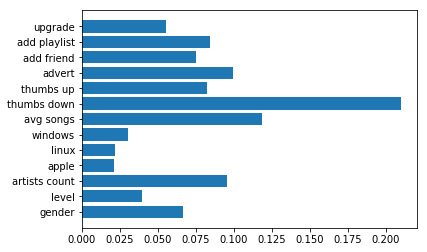

In [62]:
# display the features importance for the model
rf_model = model.stages[2].featureImportances
plt.barh(y=input_cols, width=rf_model.values);

#### Model 2: Gradient-Boosted Trees Classifier

In [68]:
# create a Gradient-Boosted Trees classifier
gbt = GBTClassifier(labelCol="churn", featuresCol="scaled_features", seed=1234)

In [69]:
# build pipeline
gbt_pipeline = Pipeline(stages = [assembler, scaler, gbt])

# train the model
model = gbt_pipeline.fit(train)

# predict churn
preds = model.transform(test)

In [70]:
# Select example rows to display.
preds.select("prediction", "churn").show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [71]:
# Select (prediction, true label) and compute f1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

# show the F1 score
gbt_score = evaluator.evaluate(preds)
print("f1 score: ", gbt_score)

# compute the accuracy
gbt_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", gbt_accuracy)

f1 score:  0.7702933025061878
accuracy:  0.7755102040816326


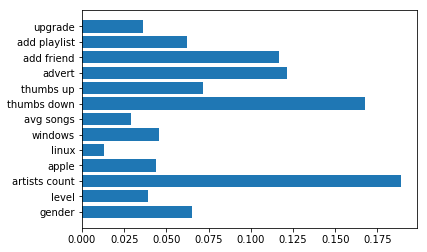

In [72]:
# display the features importance for the model
gbt_model = model.stages[2].featureImportances
plt.barh(y=input_cols, width=gbt_model.values);

#### Model 3: Multilayer Perceptron Classifier

In [73]:
# create a Multilayer Perceptron classifier
mlp = MultilayerPerceptronClassifier(labelCol="churn", featuresCol="scaled_features", layers=[13, 25, 25, 10, 2], seed=1234)

In [74]:
# build pipeline
mlp_pipeline = Pipeline(stages = [assembler, scaler, mlp])

# train the model
model = mlp_pipeline.fit(train)

# predict churn
preds = model.transform(test)

In [75]:
# Select example rows to display.
preds.select("prediction", "churn").show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [76]:
# Select (prediction, true label) and compute f1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

# show the F1 score
mlp_score = evaluator.evaluate(preds)
print("f1 score: ", mlp_score)

# compute the accuracy
mlp_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", mlp_accuracy)

f1 score:  0.8172983479105927
accuracy:  0.8367346938775511


In [77]:
# display the network weights
mlp_model = model.stages[2].weights
mlp_model

DenseVector([0.5618, 0.7213, -0.0924, -1.2153, 0.6607, 0.1318, -1.6281, 0.014, -0.1139, 0.4104, 0.448, -0.9666, -0.3079, -0.5381, -0.3723, 0.2437, -0.6767, 0.7265, 0.0009, -0.7418, -0.9062, 0.4004, -0.7576, 0.37, -1.4497, -2.652, 1.5057, 0.2932, -1.2431, 0.965, -0.1456, 0.9056, 0.4018, 0.1986, 1.3709, -0.9647, -1.0267, -0.8895, -1.9441, -0.4845, 0.4892, 1.0795, 1.9293, -2.0171, 1.0792, 1.6329, -0.4981, -1.8726, -0.4513, -2.3242, 9.1318, -3.2978, 4.1606, 5.8986, -12.3025, -0.4704, 0.4272, -0.5606, 2.013, -3.322, 1.4369, 3.2707, 3.981, 8.9034, -0.0948, -1.3416, -0.4043, -21.1636, 5.1929, 0.0114, 0.4281, -3.3378, 6.1475, -4.2057, 8.865, 1.1578, -0.3608, 0.0919, 0.8452, -0.3604, 0.1112, 0.1691, -0.7252, 0.3919, -0.9933, 0.395, 1.0119, 0.3774, 1.6041, 0.5503, -0.0522, -0.7701, -1.4983, 0.3074, 0.1682, -1.082, 0.608, 1.4364, -0.3066, 0.6673, -4.9552, 1.9413, -0.2107, -0.7513, 2.1589, 0.2238, 0.6185, 0.5786, 0.3815, 1.1286, -1.2284, -1.4295, -1.4382, -4.3063, -0.9586, 1.7606, 0.9553, 4.5245, 

The Random Forest Classifier and Multilayer Perceptron Classifier model provided the highest F1 score as well as the highest accuracy. We will therefore be tuning a few parameters of both models and measure them on their accuracy on the validation set.

#### Tuning Multilayer perceptron classifier

In [78]:
# build the parameters grid. In our case we will only adjust the layers to assess impact, and select the best model.
mlp_paramGrid = ParamGridBuilder() \
    .addGrid(mlp.layers, [[13, 25, 10, 2], 
                          [13, 25, 25, 10, 2],
                          [13, 25, 25, 25, 10, 2], 
                          [13, 40, 80, 60, 20, 8, 2]]) \
    .build()

In [79]:
# create the cross validator
mlp_crossval = CrossValidator(estimator=mlp_pipeline,
                          estimatorParamMaps=mlp_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1"),
                          numFolds=3)

# run the models
mlp_cvModel = mlp_crossval.fit(train)
mlp_cvModel.avgMetrics

[0.6613772200740634,
 0.6156785603180656,
 0.6267489663242353,
 0.6417569098462167]

In [80]:
mlp_tuned_score = max(mlp_cvModel.avgMetrics)
mlp_tuned_score

0.6613772200740634

In [81]:
# compute predictions using the tuned model
preds = mlp_cvModel.transform(test)

# compute the accuracy on the test set
mlp_tuned_accuracy = accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", mlp_tuned_accuracy)

accuracy:  0.8163265306122449


In [82]:
# show details about the best model from the tuning
bestPipeline = mlp_cvModel.bestModel
bestMLPModel = bestPipeline.stages[2]
bestMLPModel.layers

[13, 25, 10, 2]

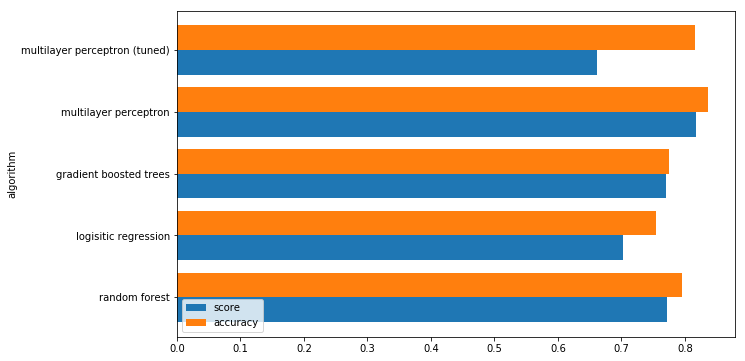

In [84]:
# display a summary of all the models performance
summary = [[rf_score, rf_accuracy], \
           [lr_score, lr_accuracy], \
           [gbt_score, gbt_accuracy], \
           [mlp_score, mlp_accuracy], \
           [mlp_tuned_score, mlp_tuned_accuracy]]

summary_df = pd.DataFrame(summary, columns=['score','accuracy'], \
                          index=['random forest', 'logisitic regression', 'gradient boosted trees', 'multilayer perceptron', 'multilayer perceptron (tuned)'])

import numpy as np
y = np.arange(len(summary_df.index))
height = 0.4
fig, ax = plt.subplots(figsize=(10,6))
plt_score = ax.barh(y - height/2, summary_df.score, height, label='score')
plt_accuracy = ax.barh(y + height/2, summary_df.accuracy, height, label='accuracy')
ax.set_ylabel('algorithm')
ax.set_yticks(y)
ax.set_yticklabels(summary_df.index)
ax.legend(loc="lower left");

The best model after tuning in our case is the Multilayer Perceptron classifier, which got a higher F1 score.
We are now evaluating its accuracy on the validation dataset.

In [85]:
# compute predictions using the tuned model
preds = mlp_cvModel.transform(valid)

# compute the accuracy on the validation set
accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", accuracy)

accuracy:  0.7735849056603774


In [86]:
# check number of churn vs. non-churn users in the validation set
print("number of non-churn users: ", preds[preds.churn == 0].count())
print("total number of users: ", preds.count())

number of non-churn users:  41
total number of users:  53


# Conclusion

After running the best model on the validation data, we managed to achieve an accuracy of 79.2%. This results is quite good, based on the small size of our dataset, and the relative small portion of churn users in the dataset. That latter point is also the reason why we optimised the model on the F1 metric, as otherwise a dumb model which would only output zero as a prediction would still be able to get a high accuracy even though it would not generate any real positive, but would generate a lot of false negatives instead. In theory this dumb classifier would get a 77.3% on the validation set : 41 (=non-churn users) / 53 (=total number of users)

The successful model is the Multilayer Perceptron classifier. I could not manage to get to a higher accuracy by tuning the model, however we managed to get a result above what we would expect from a dumb classifier.

This data analysis would benefit from being run on the full dataset, and this should be a future enhancement for this work. Getting an AWS cluster up and running is not a very complex task, and the whole notebook should be executed there.

When I get the time (after this project submission), I will spin up a spark cluster and rerun the whole notebook on the large dataset to see if the volume of data allows either a better training of the models (and therefore higher accuracy) or allows to really identify one of the 2 models which performs better. These results will be posted in this github repository.

### Learnings

I learnt many things in this project, especially how to use pyspark to handle a large dataset and distribute the data and computations to a cluster of machines.

I liked the functional programming approach that is necessary when running distributed computations (to make parallelisation of work easier, and to run calculations on chunks of data).

Pyspark provides a number of models and the fact it is built by following a similar logic as sklearn is helpful to get started more easily, however I find the structure of the pyspark documentation less convenient to work with that sklearn. It was not very easy to find the relevant information in the very long pages of the API documentation of spark. However I am likely to use it again since the problems of data science are oftern beyond the capabilities of the memory of a single computer.

This project gives exposure to spark environment to analyze a large volume of data that a personal laptop may not be capable to analyze. By identifying customer with high chance to churn prior to the acutal losing, companies are able to use minimal cost to save customers by using targeted messages and offers.

One of the interesting yet difficult things during the project is brainstroming the features that we can derived from the data we have on hand. Developing useful features is crucial to developing a good model, and requires a lot of energy and efforts. Explanatory and exploratory data analysis play important role in this process.

### Improvement
The features can be improved a lot after considering more factors, adding more domain knowledges and expertise. Although the volume of data may required tools such as spark to analyze, but we can use more data to have better results as the user base grow.

Currently, we have about 450 records of unique users, and we only use 60% of them to train. That said, the model has a huge potential to improve if the sample size increase, and the expected performance will also increase.